In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

定义模型初始化参数

In [3]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # 我们从标准差为0.01的高斯分布中提取权重
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    # 将之前的对三个隐藏层参数初始化包装在一起
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    

    # 1.遗忘门参数  
    W_xf, W_hf, b_f = three()
    # 2.输入门参数
    W_xi, W_hi, b_i = three()
    # 3.候选记忆元参数  
    W_xc, W_hc, b_c = three()
    # 4.输出门参数  
    W_xo, W_ho, b_o = three()


    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params =  [  
                W_xi, W_hi, b_i, 
                W_xf, W_hf, b_f, 
                W_xo, W_ho, b_o, 
                W_xc, W_hc, b_c, 
                W_hq, b_q
            ]
    for param in params:
        param.requires_grad_(True)
    return params

初始化模型状态

In [4]:
# 与GRU不同的是，这里需要返回两个对应state，对应了LSTM里面的一个C和一个H
def init_lstm_state(batch_size, num_hiddens, device):
    return(
        torch.zeros((batch_size, num_hiddens),device=device),
        torch.zeros((batch_size, num_hiddens),device=device),
    )

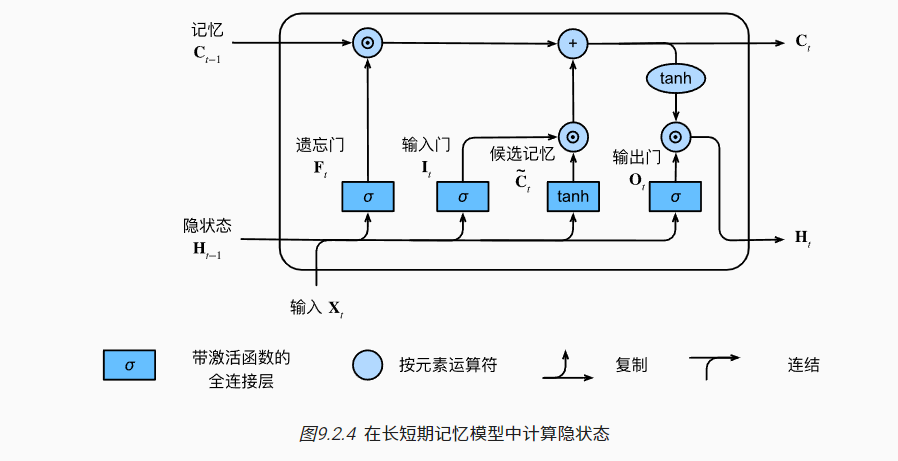

In [1]:
from IPython.display import Image
Image(filename = 'E:\Clancy\Code\动手学深度学习NLP篇\\LSTM.png', width=10, height=10)

In [6]:
def LSTM(inputs, state, params):
    [
        W_xi, W_hi, b_i, 
        W_xf, W_hf, b_f, 
        W_xo, W_ho, b_o, 
        W_xc, W_hc, b_c,
        W_hq, b_q
    ] = params
    
    # 对应两种前项结果输入
    (H,C) = state

    outputs = []
    for X in inputs:
        # 第一步 输入的状态H 统一求MLP
        # 唯一不同的是 C_tilda的激活函数是tanh
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)    # input
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)    # forget
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)    # output
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c) # Candidate

        # 第二步 对两个state C和H进行更新

        # 解释 
        #   ->这里的"遗忘门F"和"输入门I"分别控制着对上一模块传来的Ct-1和本层的信息C_tilda
        #   ->与GRU不同的是 GRU的I选择使用   H = Z * H + (1 - Z) * H_tilda 来保留信息
        #   ->不能相互独立，而lstm可以相互独立 极端情况就是对t次和t-1次的都不保留或者全部保留
        C = F * C + I * C_tilda
        # 解释
        #   ->由于C采用了加法形式，将本来两个范围在[-1~1]之间叠加到[-2~2]之间
        #   ->重新归一化好一些，并且用"输出门O"做最后调整
        H = O * torch.tanh(C)

        Y = (H @ W_hq) + b_q

        outputs.append(Y)
    return torch.cat(outputs, dim=0),(H,C)

perplexity 1.1, 30770.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


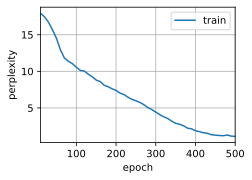

In [7]:
vocab_size = len(vocab)
num_hiddens = 256
device = d2l.try_gpu()


num_epochs = 500
lr = 1

model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, LSTM)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

API简洁表示

perplexity 1.1, 179680.0 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller fimenscher hishedsions of space been as are ul at


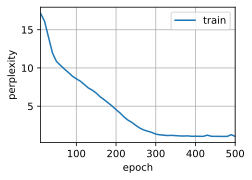

In [8]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)